In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 
sns.set_theme(style='darkgrid',palette = 'rainbow')
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 300
import warnings 
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('exchange_rate.csv')
data.head()

date  Ex_rate
0  01-01-1990 00:00   0.7855
1  02-01-1990 00:00   0.7818
2  03-01-1990 00:00   0.7867
3  04-01-1990 00:00   0.7860
4  05-01-1990 00:00   0.7849

In [3]:
data.shape

(7588, 2)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [5]:
data.duplicated().sum()

0

In [6]:
data.isna().sum()

date       0
Ex_rate    0
dtype: int64

<Axes: >

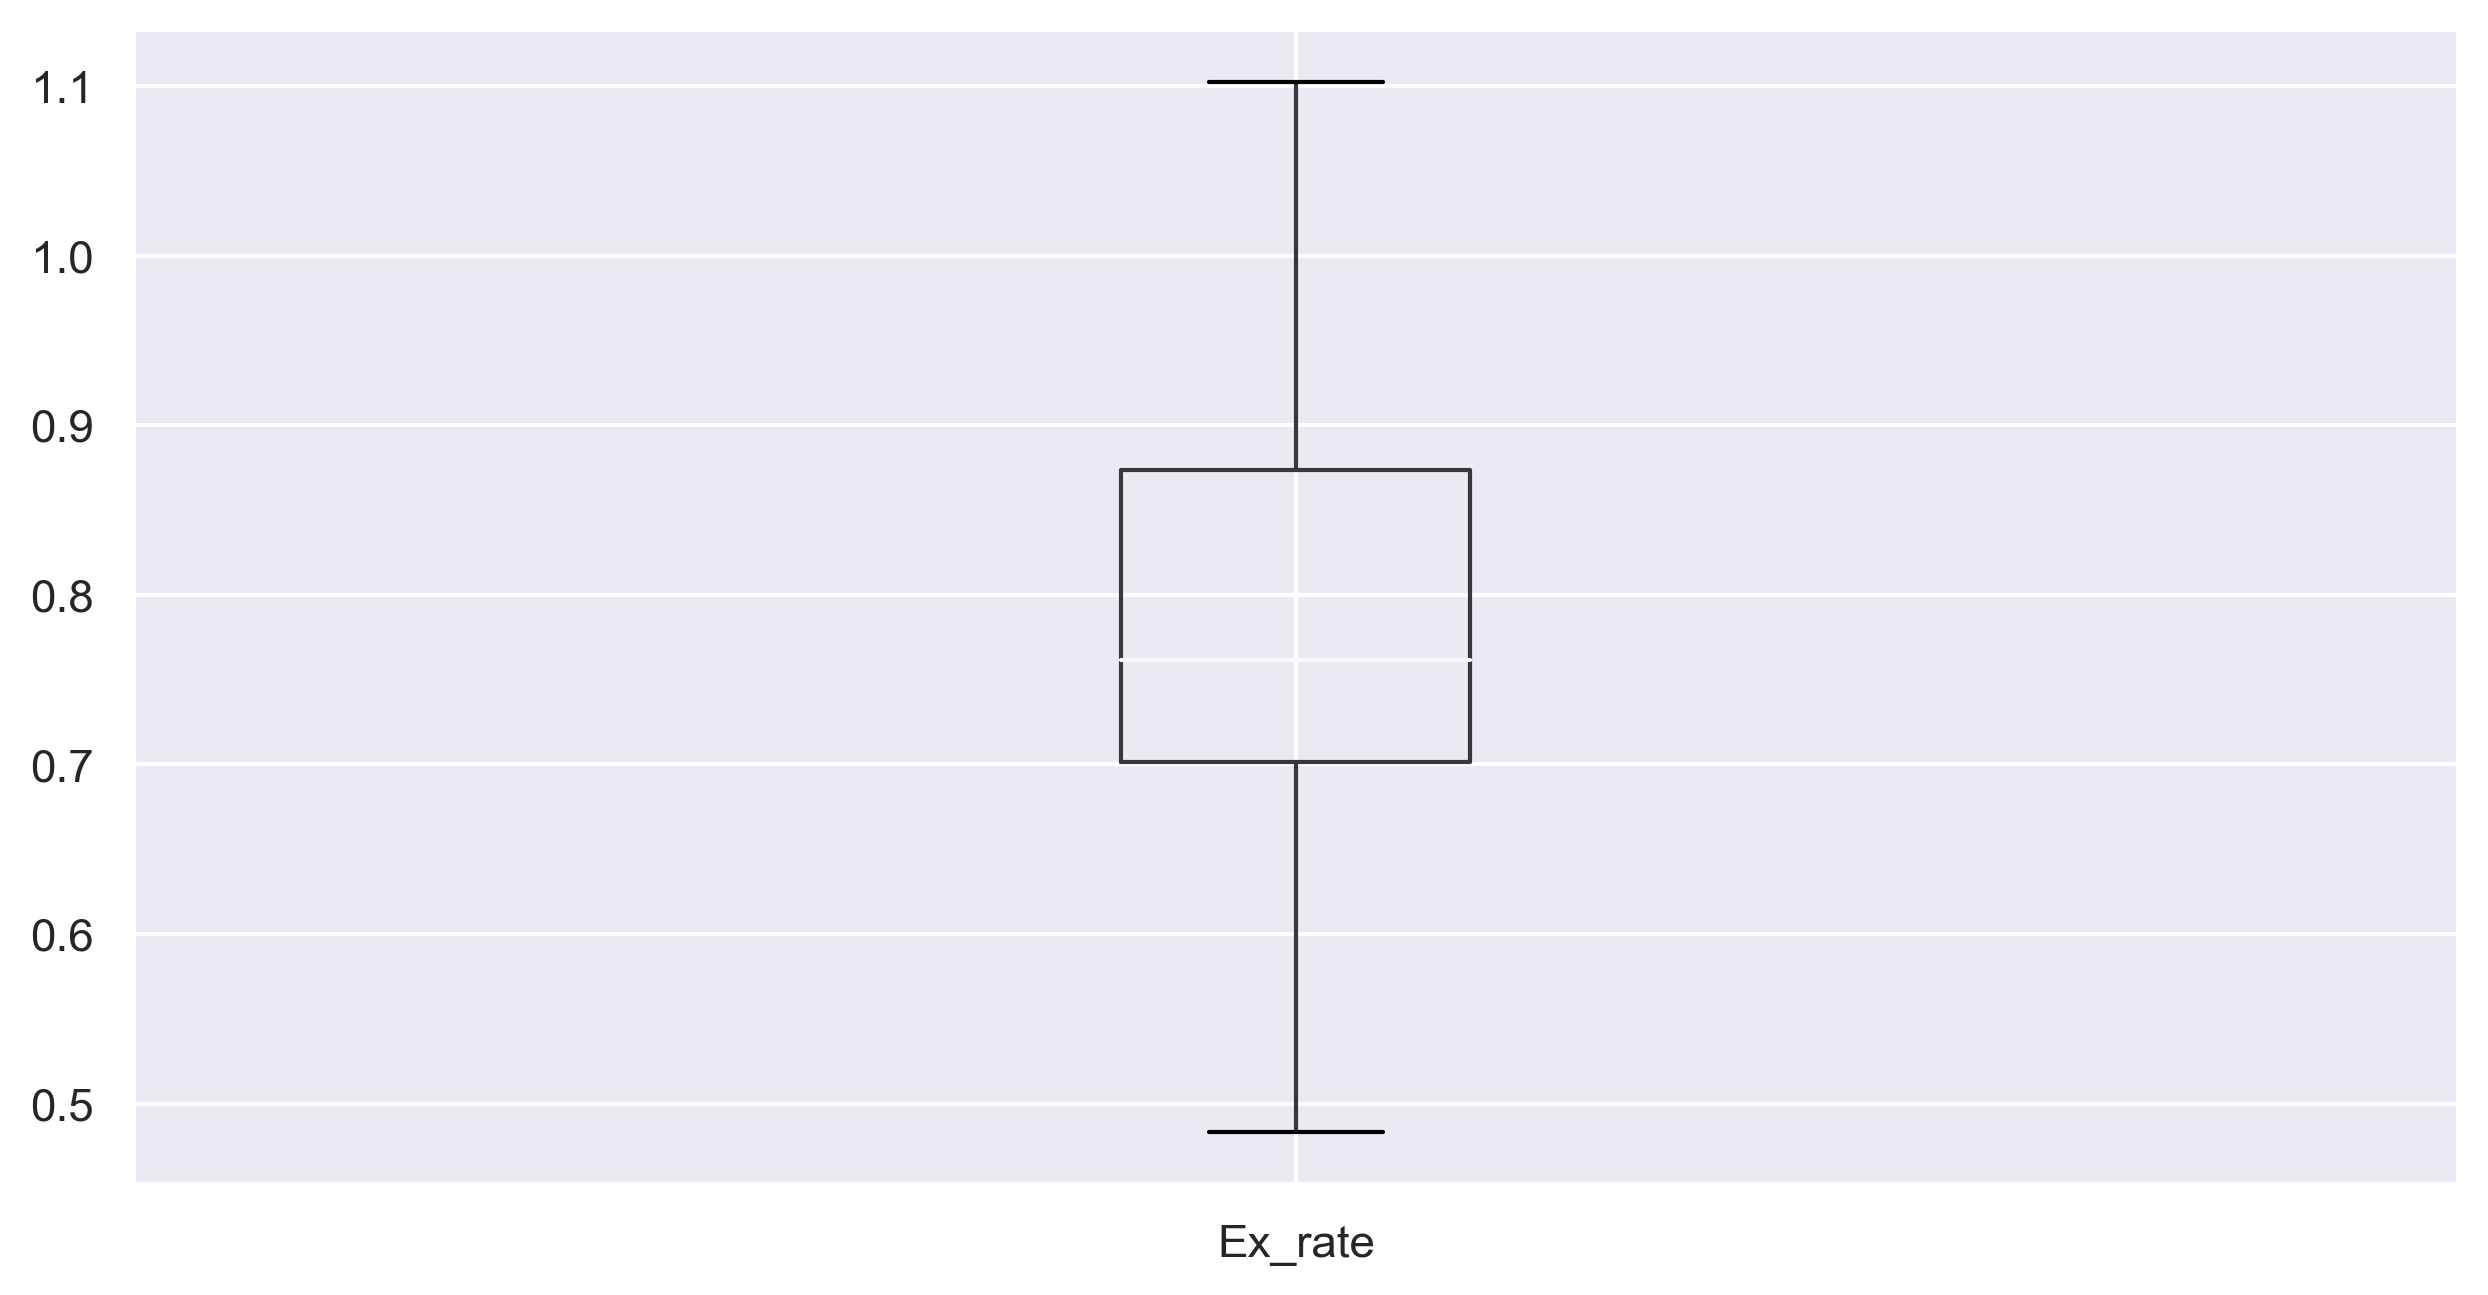

In [7]:
data.boxplot()

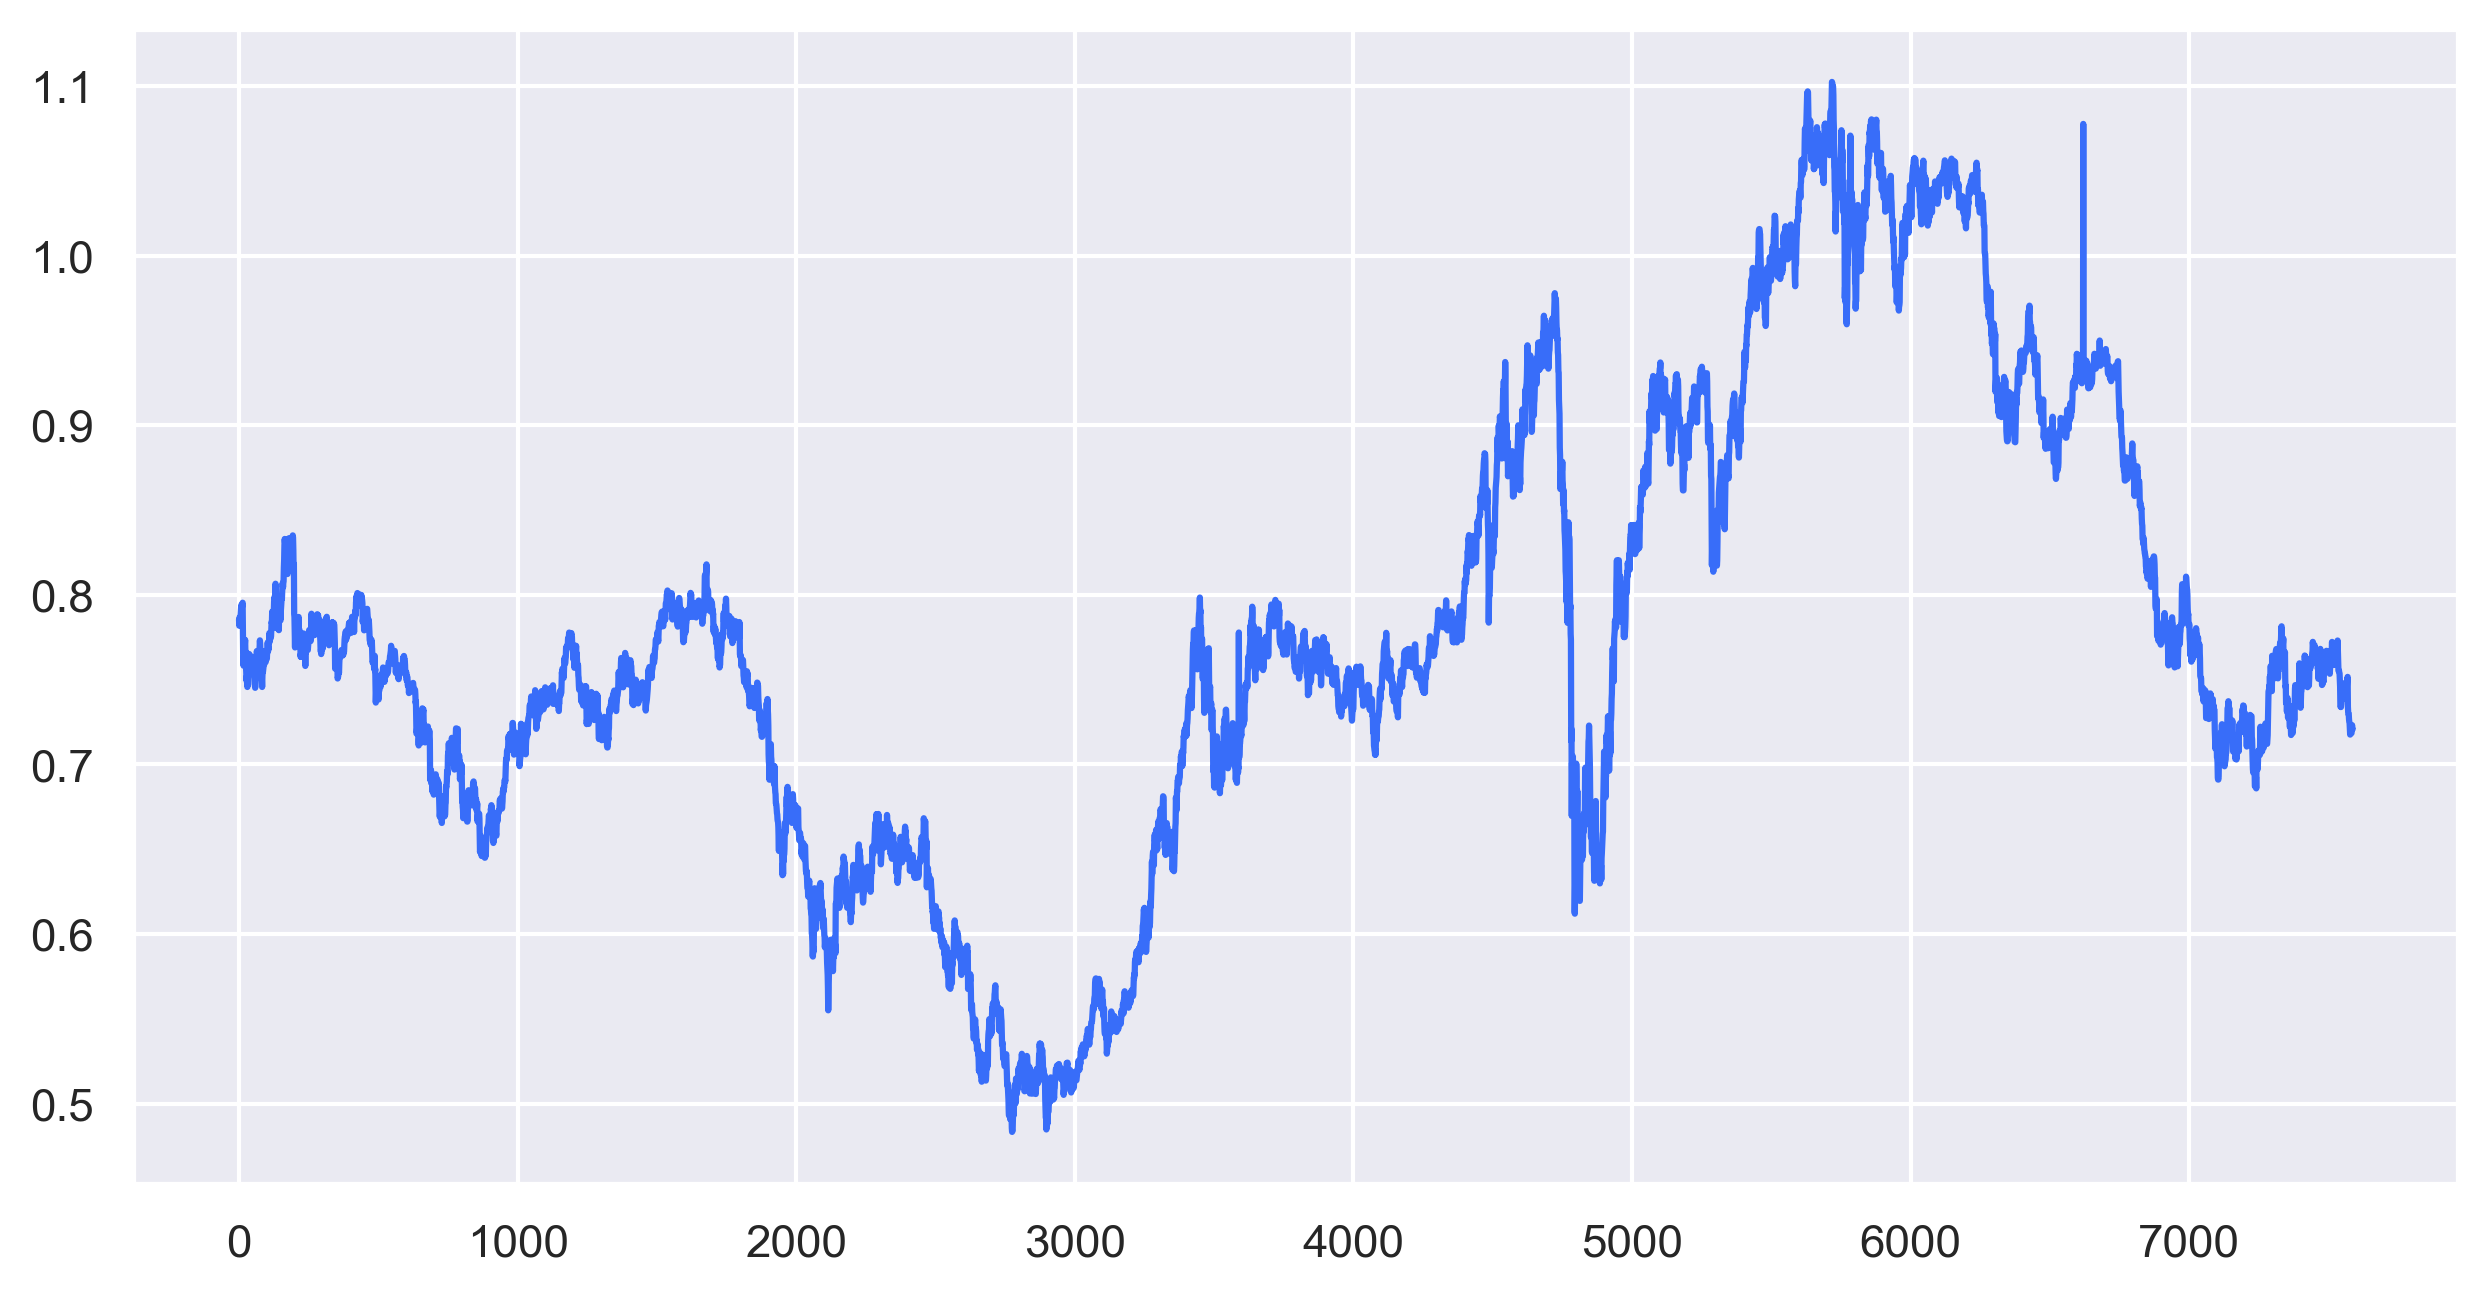

In [8]:
plt.plot(data['Ex_rate'])

#### Model Building - ARIMA

In [9]:
# Parameter Selection for ARIMA 
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [10]:
exchange_rate = data['Ex_rate']

In [11]:
adf_result = adfuller(exchange_rate)
print(f"ADF Statistic :{adf_result[0]}")
print(f"p-value :{adf_result[1]}")

ADF Statistic :-1.6649941807381512
p-value :0.44923273535979097


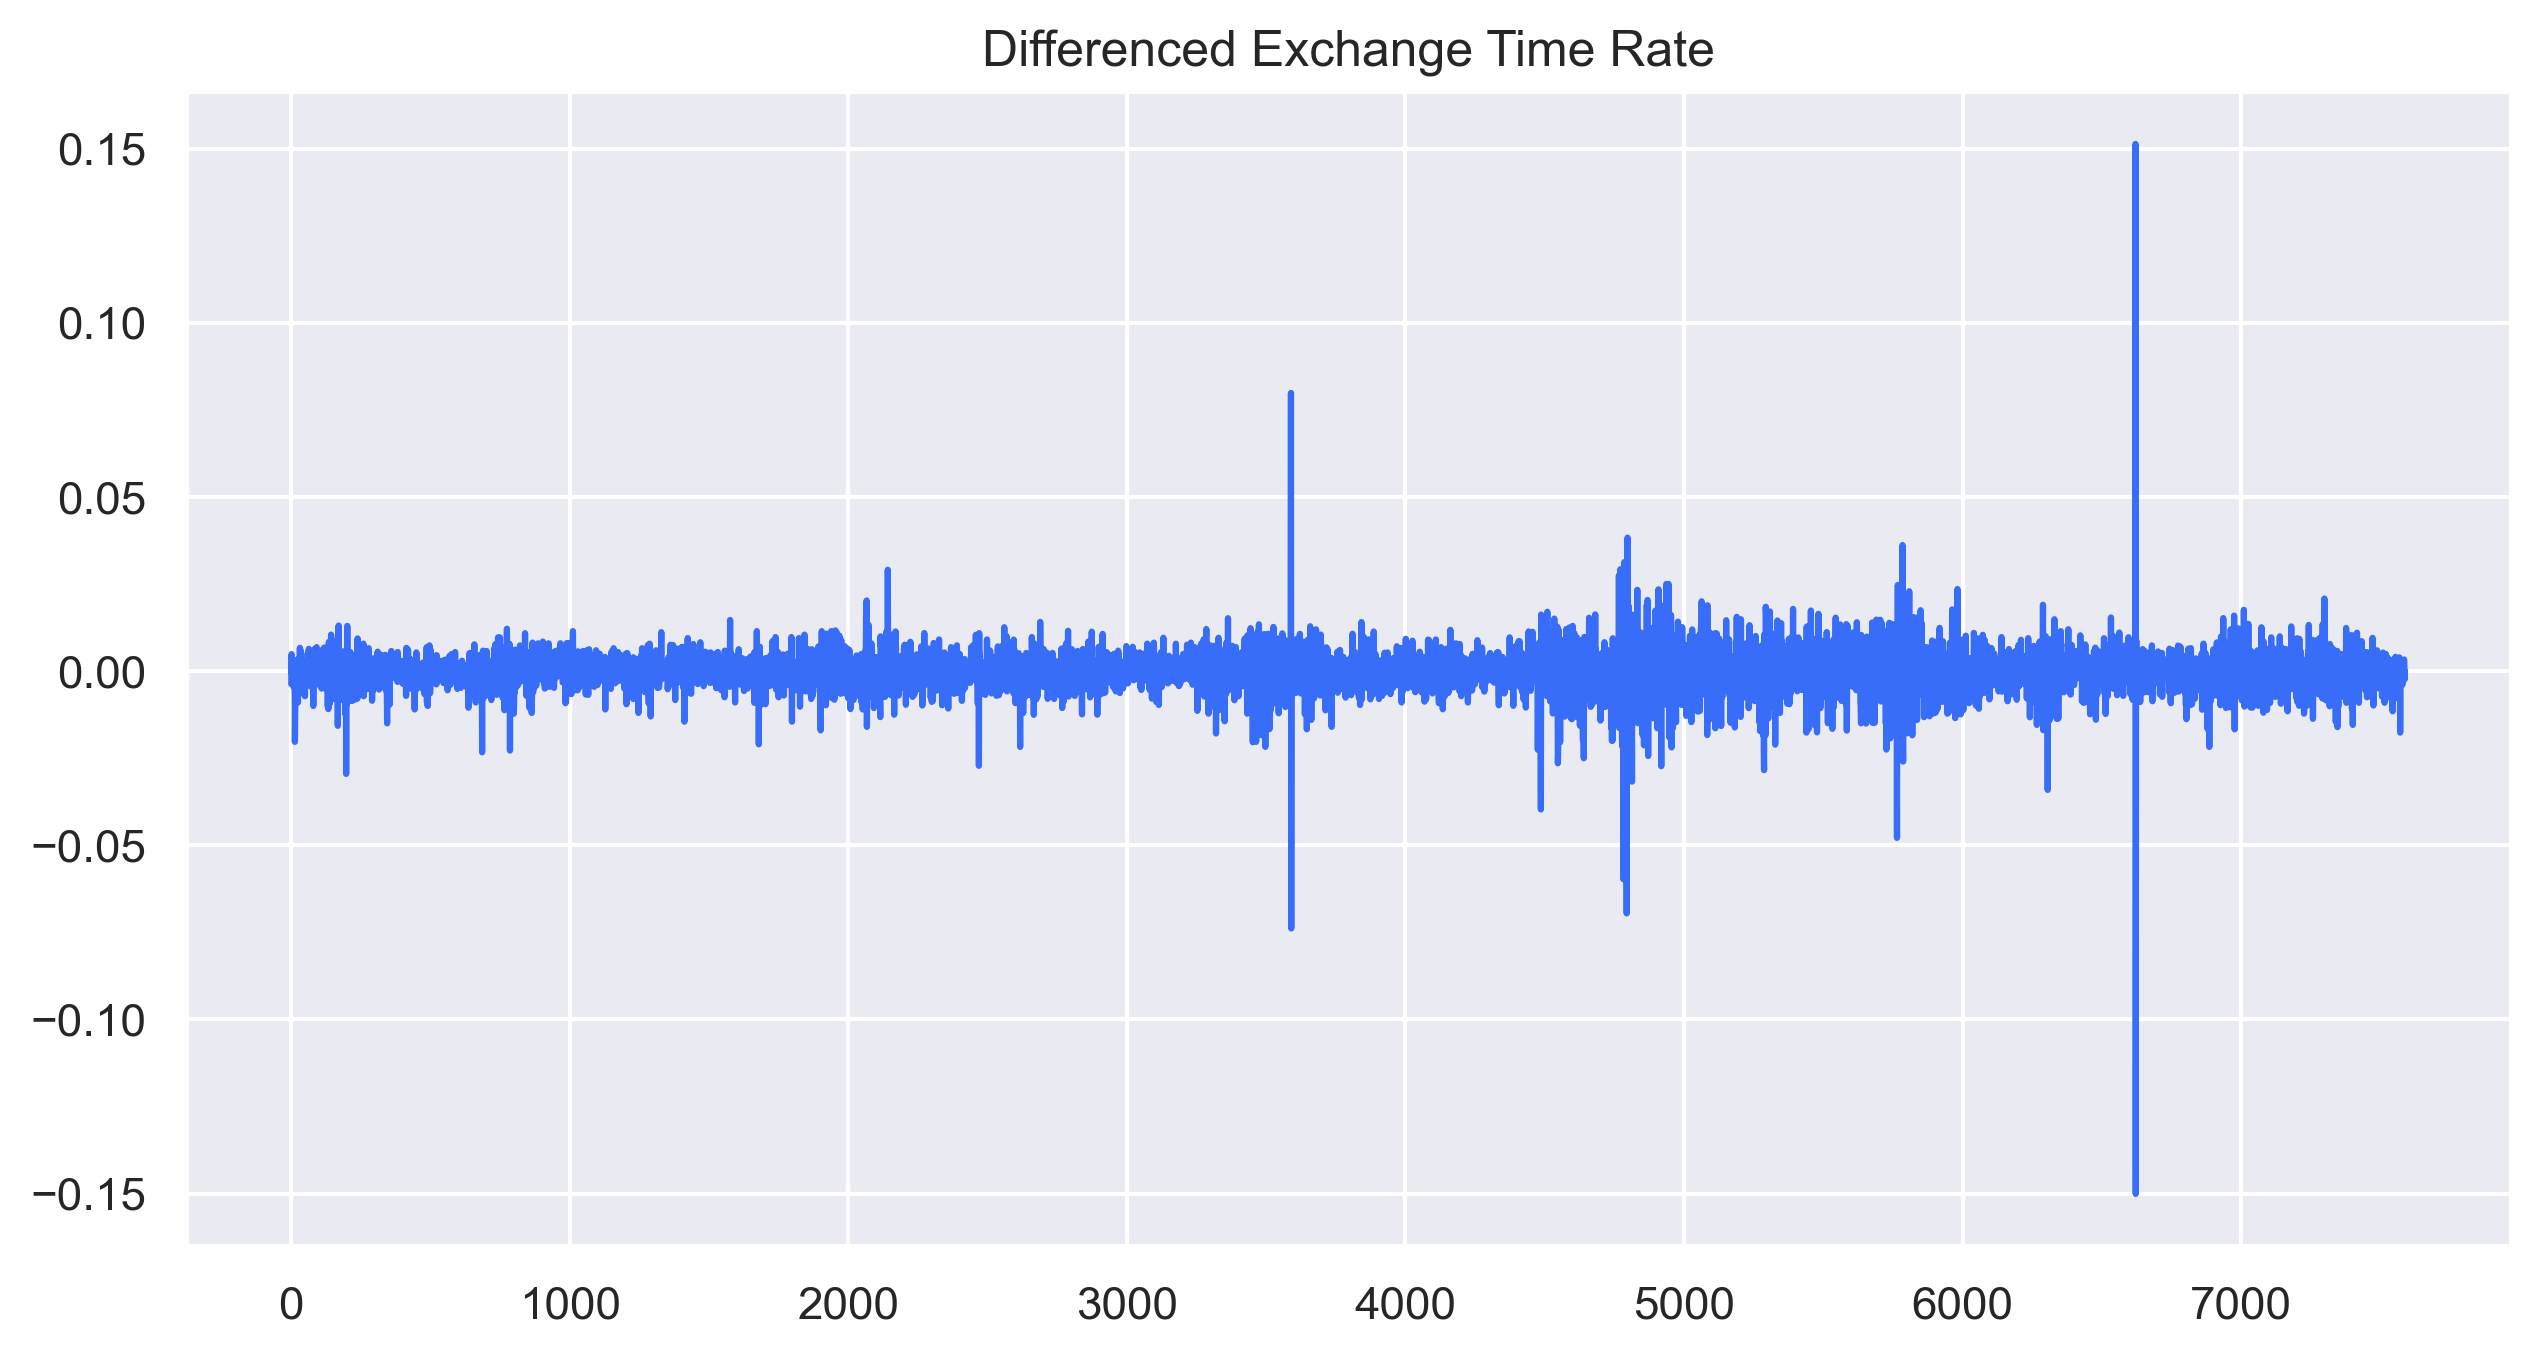

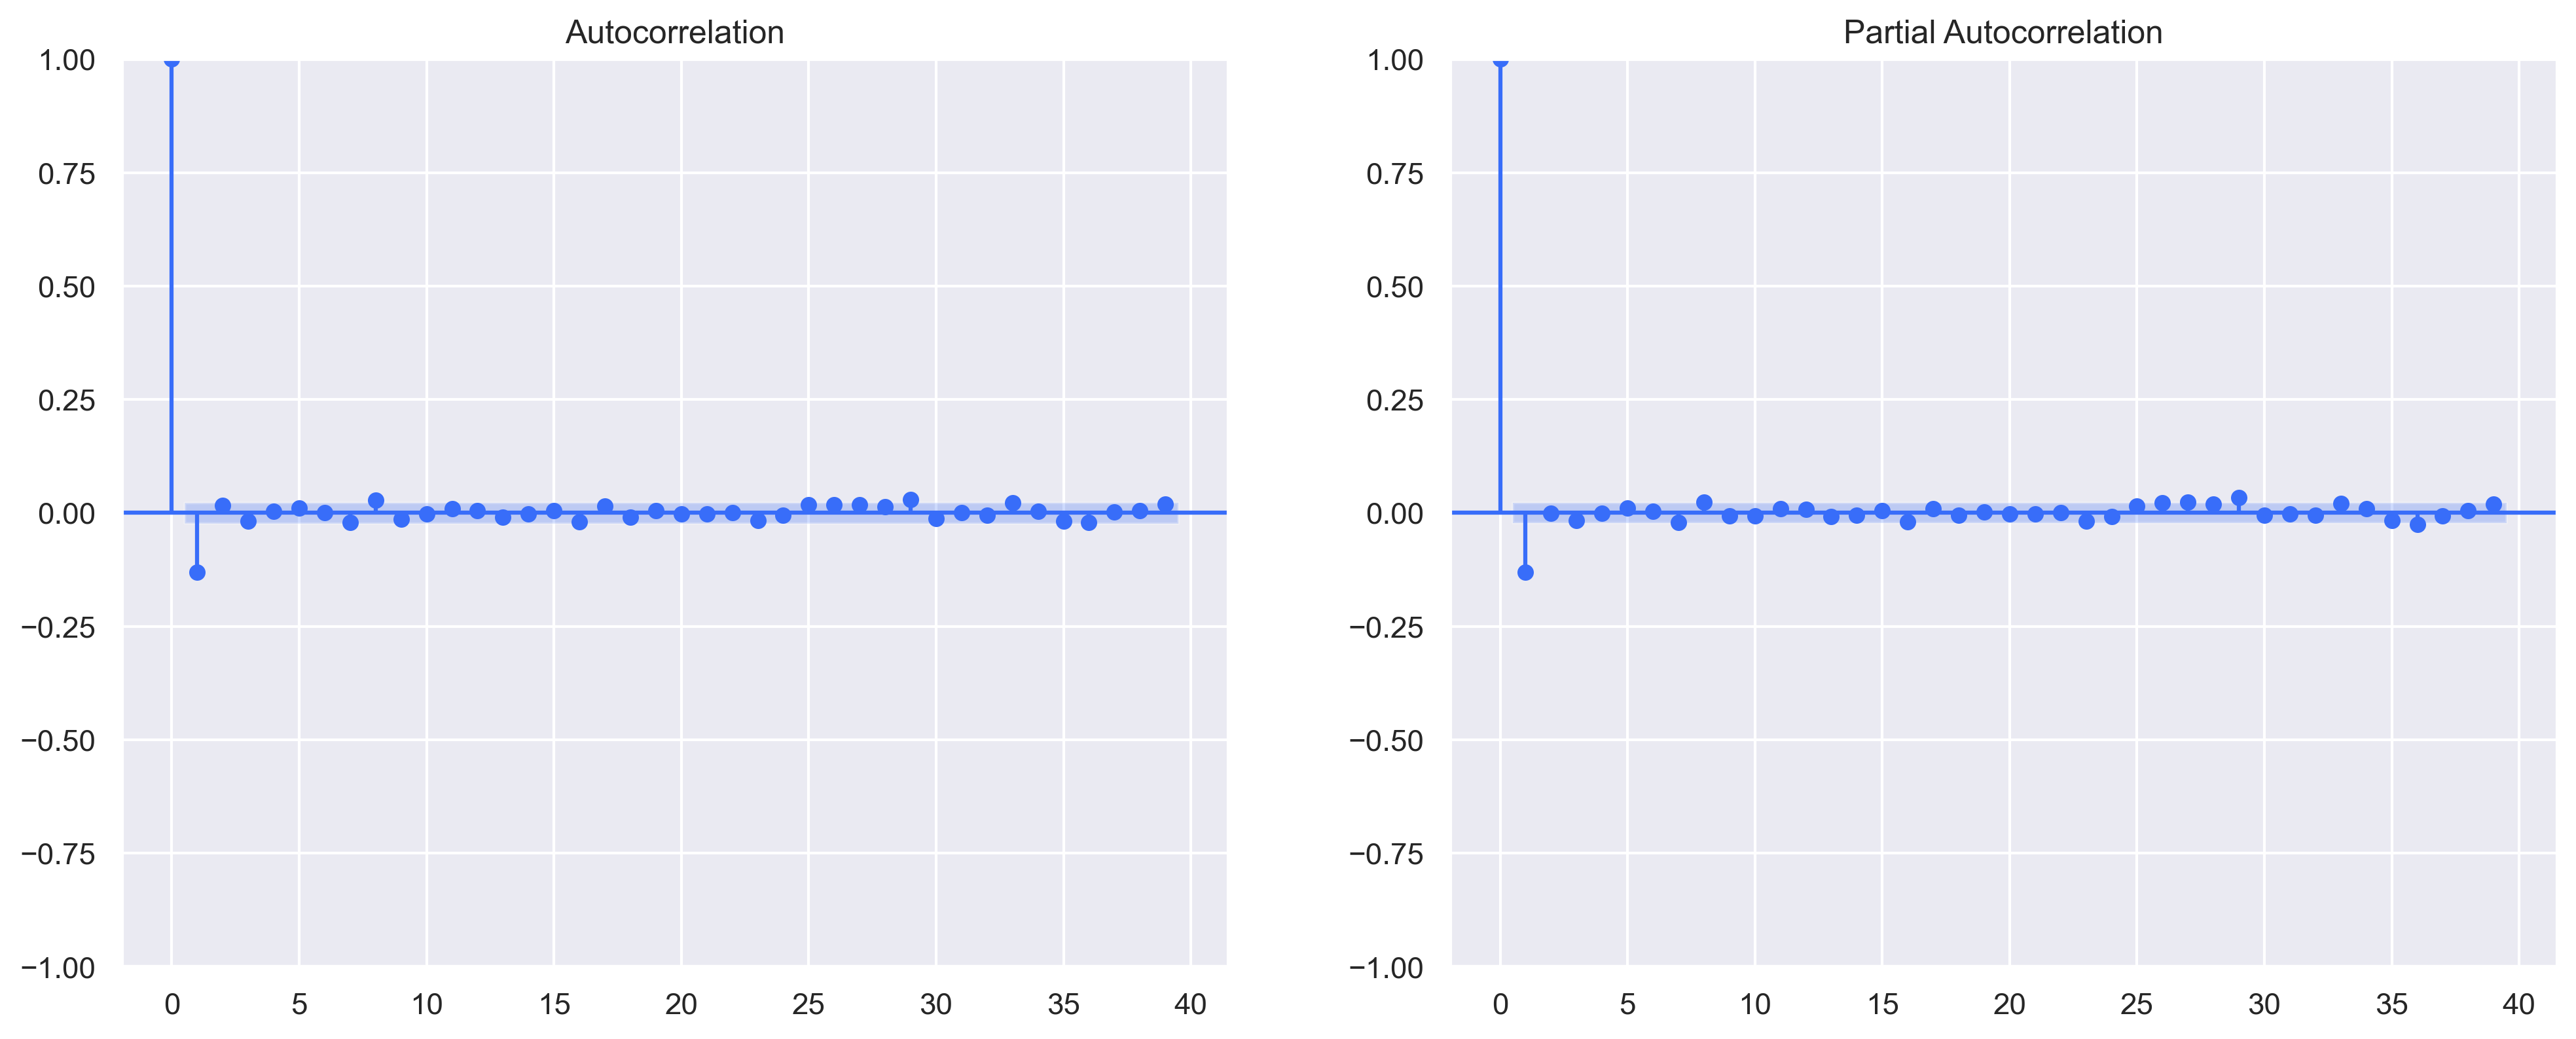

In [12]:
# if p-value is > 0.05, data is non-stationary, apply differencing
if adf_result[1]>0.05:
    exchange_rate_diff = exchange_rate.diff().dropna()
    plt.plot(exchange_rate_diff)
    plt.title("Differenced Exchange Time Rate")
    plt.show()
    
    fig, axes = plt.subplots(1, 2, figsize=(16,6))
    plot_acf(exchange_rate_diff, ax=axes[0])
    plot_pacf(exchange_rate_diff, ax=axes[1])
    plt.show()
else:
    print("Series is already stationary; no differencing needed.")

In [13]:
# model fitting
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(exchange_rate,order=(1,1,1))

In [14]:
model_fit = model.fit()

In [15]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Mon, 07 Oct 2024   AIC                         -56102.322
Time:                        12:07:05   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

In [16]:
# diagnostics
residuals = model_fit.resid

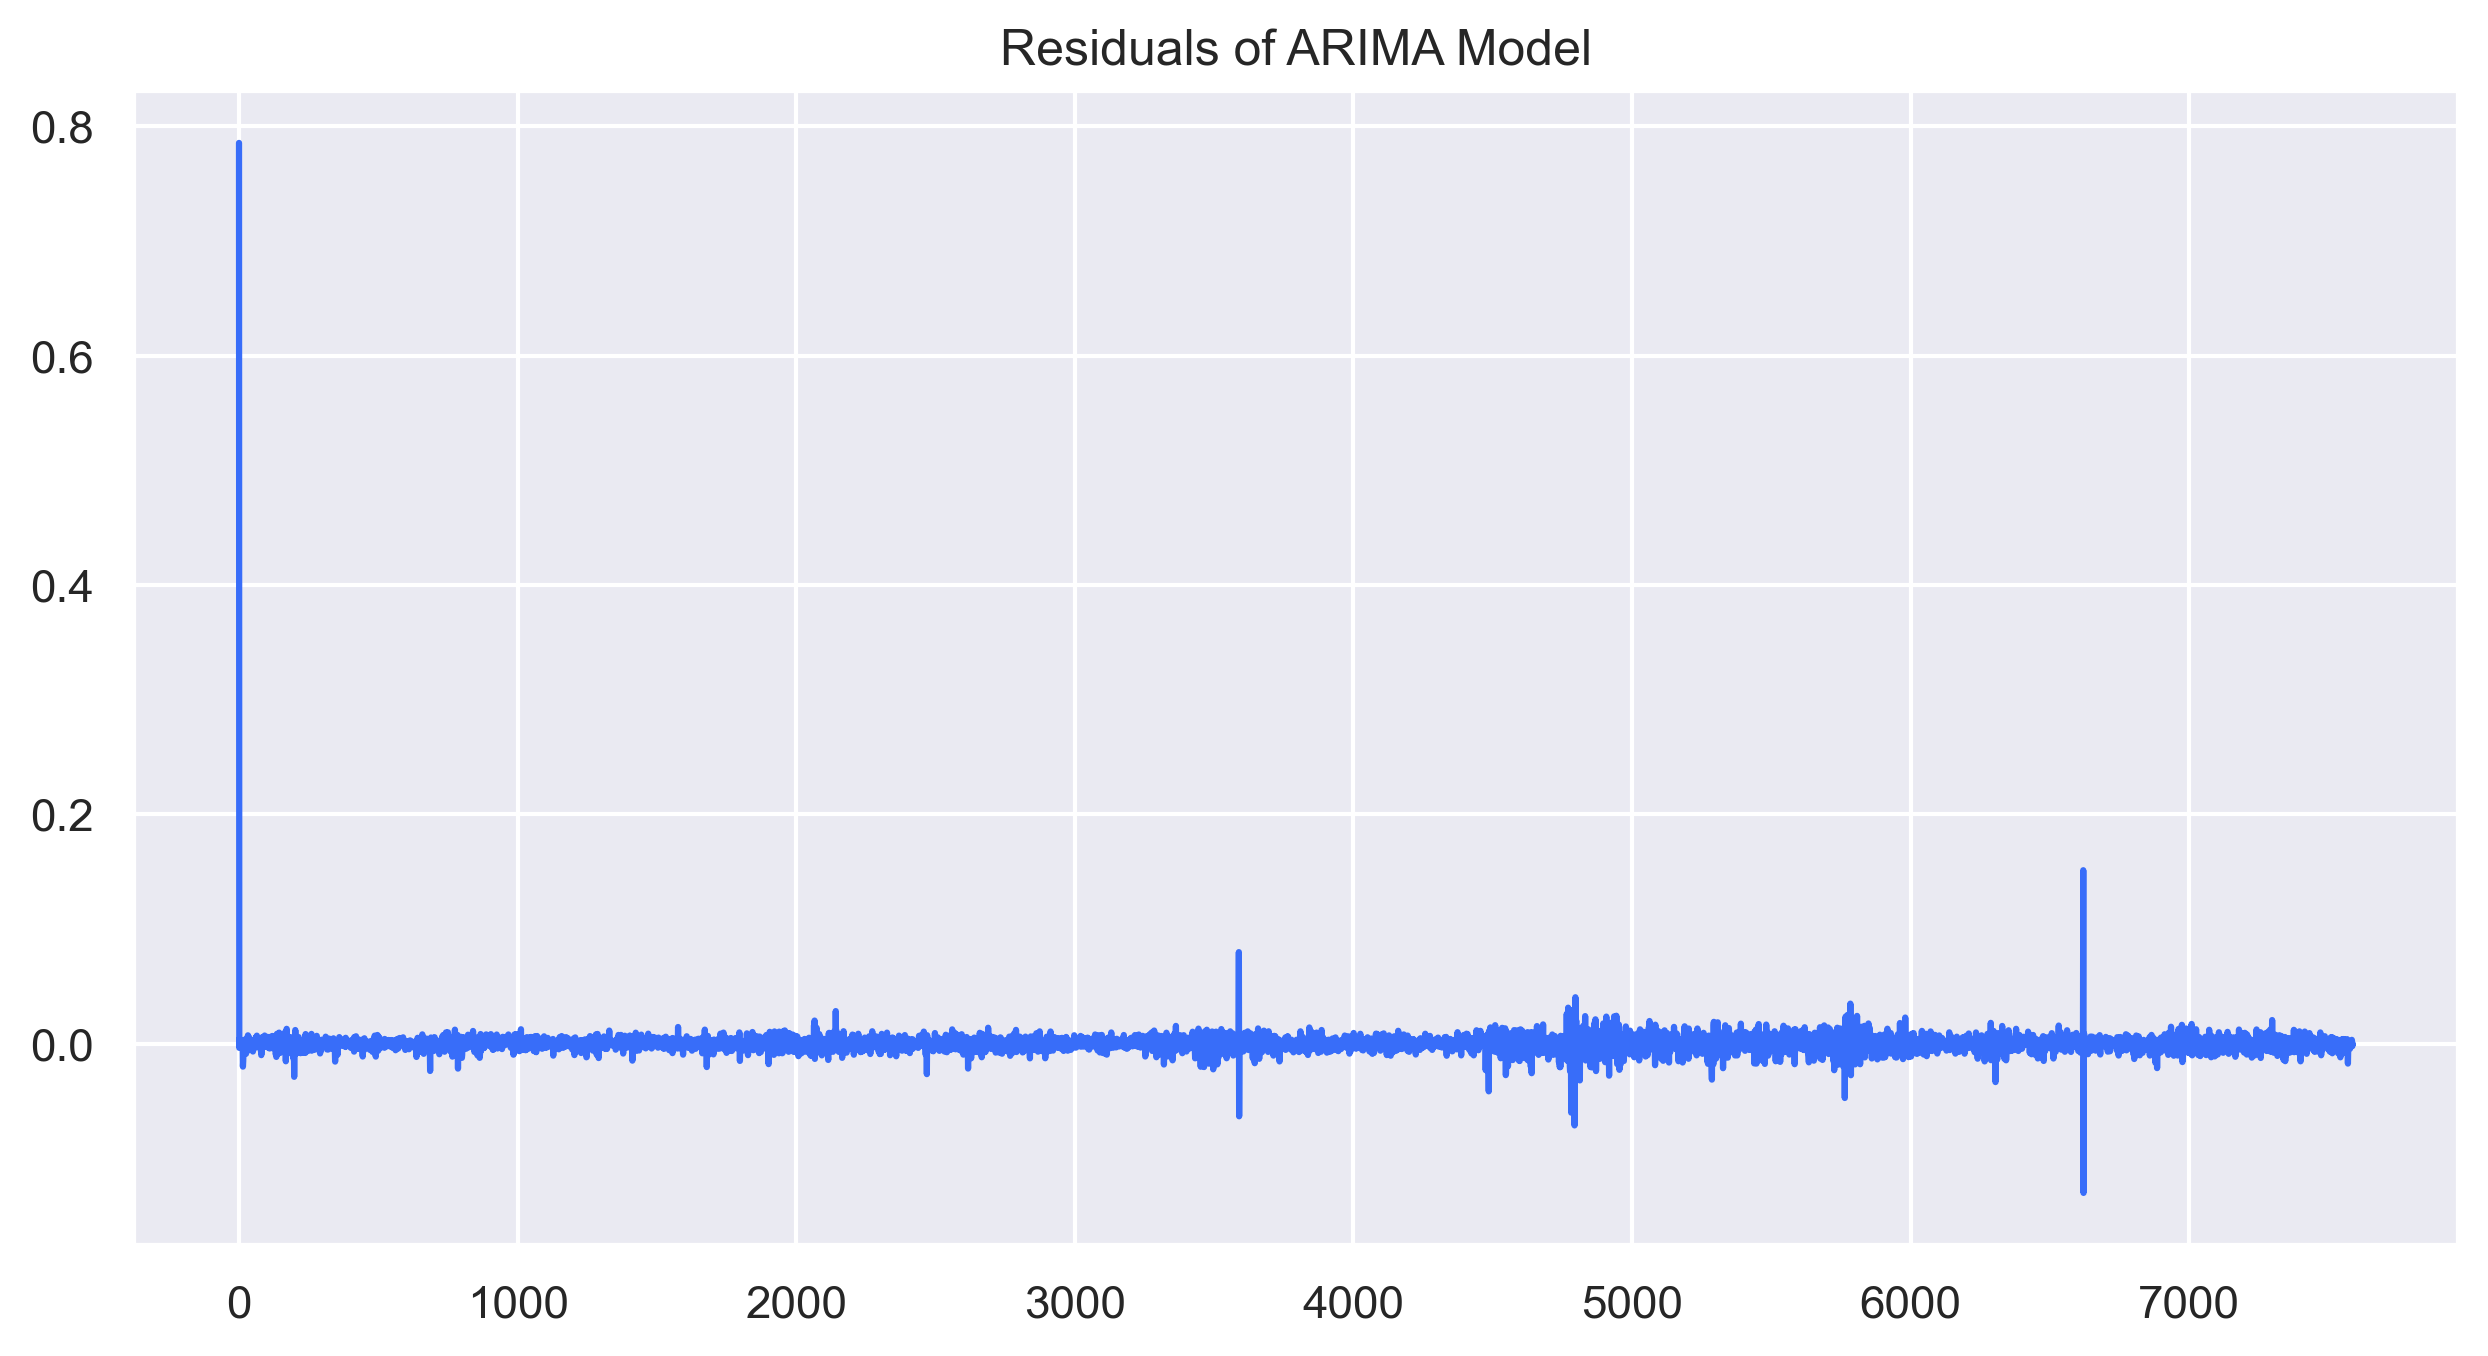

In [17]:
# plotting Residual for ARIMA model 
plt.plot(residuals)
plt.title("Residuals of ARIMA Model")
plt.show()

In [18]:
# forecasting
forecast_steps = 10 
forecast = model_fit.get_forecast(steps = forecast_steps)

In [19]:
# extracting forecasted mean and confidence intefvals 
forecast_mean = forecast.predicted_mean 
conf_interval = forecast.conf_int()

In [20]:
# plotting forecasts vs actuals
plt.figure(figsize=(10, 6))
plt.plot(exchange_rate, label='Actual Exchange Rate', color='blue')
plt.plot(np.arange(len(exchange_rate), len(exchange_rate) + forecast_steps), forecast_mean, label='Forecasted Exchange Rate', color='red')
plt.fill_between(np.arange(len(exchange_rate), len(exchange_rate) + forecast_steps), 
                 conf_interval.iloc[:, 0], conf_interval.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Exchange Rate Forecast')
plt.legend()
plt.show()

#### Model Building - Exponential Smoothing

In [21]:
# model selection 
# from the above graphs and plots, it seems that there could be a trend but no indication of strong seasonality 
# so we will use Holt's Linear Trend Model 

In [23]:
# parameter optimization 
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import itertools

In [28]:
def optimize_es(time_series,alphas,betas):
    best_aic = float('inf')
    best_params = None
    best_model = None
    
    for alpha,beta in itertools.product(alphas,betas):
        model = ExponentialSmoothing(time_series,trend='add').fit(smoothing_level=alpha,smoothing_slope=beta)
        aic = model.aic 
        
        if aic < best_aic :
            best_aic = aic
            best_params = (alpha,beta)
            best_model = model 
    return best_model,best_params

In [29]:
alphas = [0.1, 0.3, 0.5, 0.7, 0.9]
betas = [0.1, 0.3, 0.5, 0.7, 0.9]
best_model, best_params = optimize_es(exchange_rate,alphas,betas)

In [32]:
# Model Fitting and Forecasting
final_model = ExponentialSmoothing(exchange_rate,trend='add').fit(smoothing_level=best_params[0],smoothing_slope=best_params[1])
forecast = final_model.forecast(steps=100)

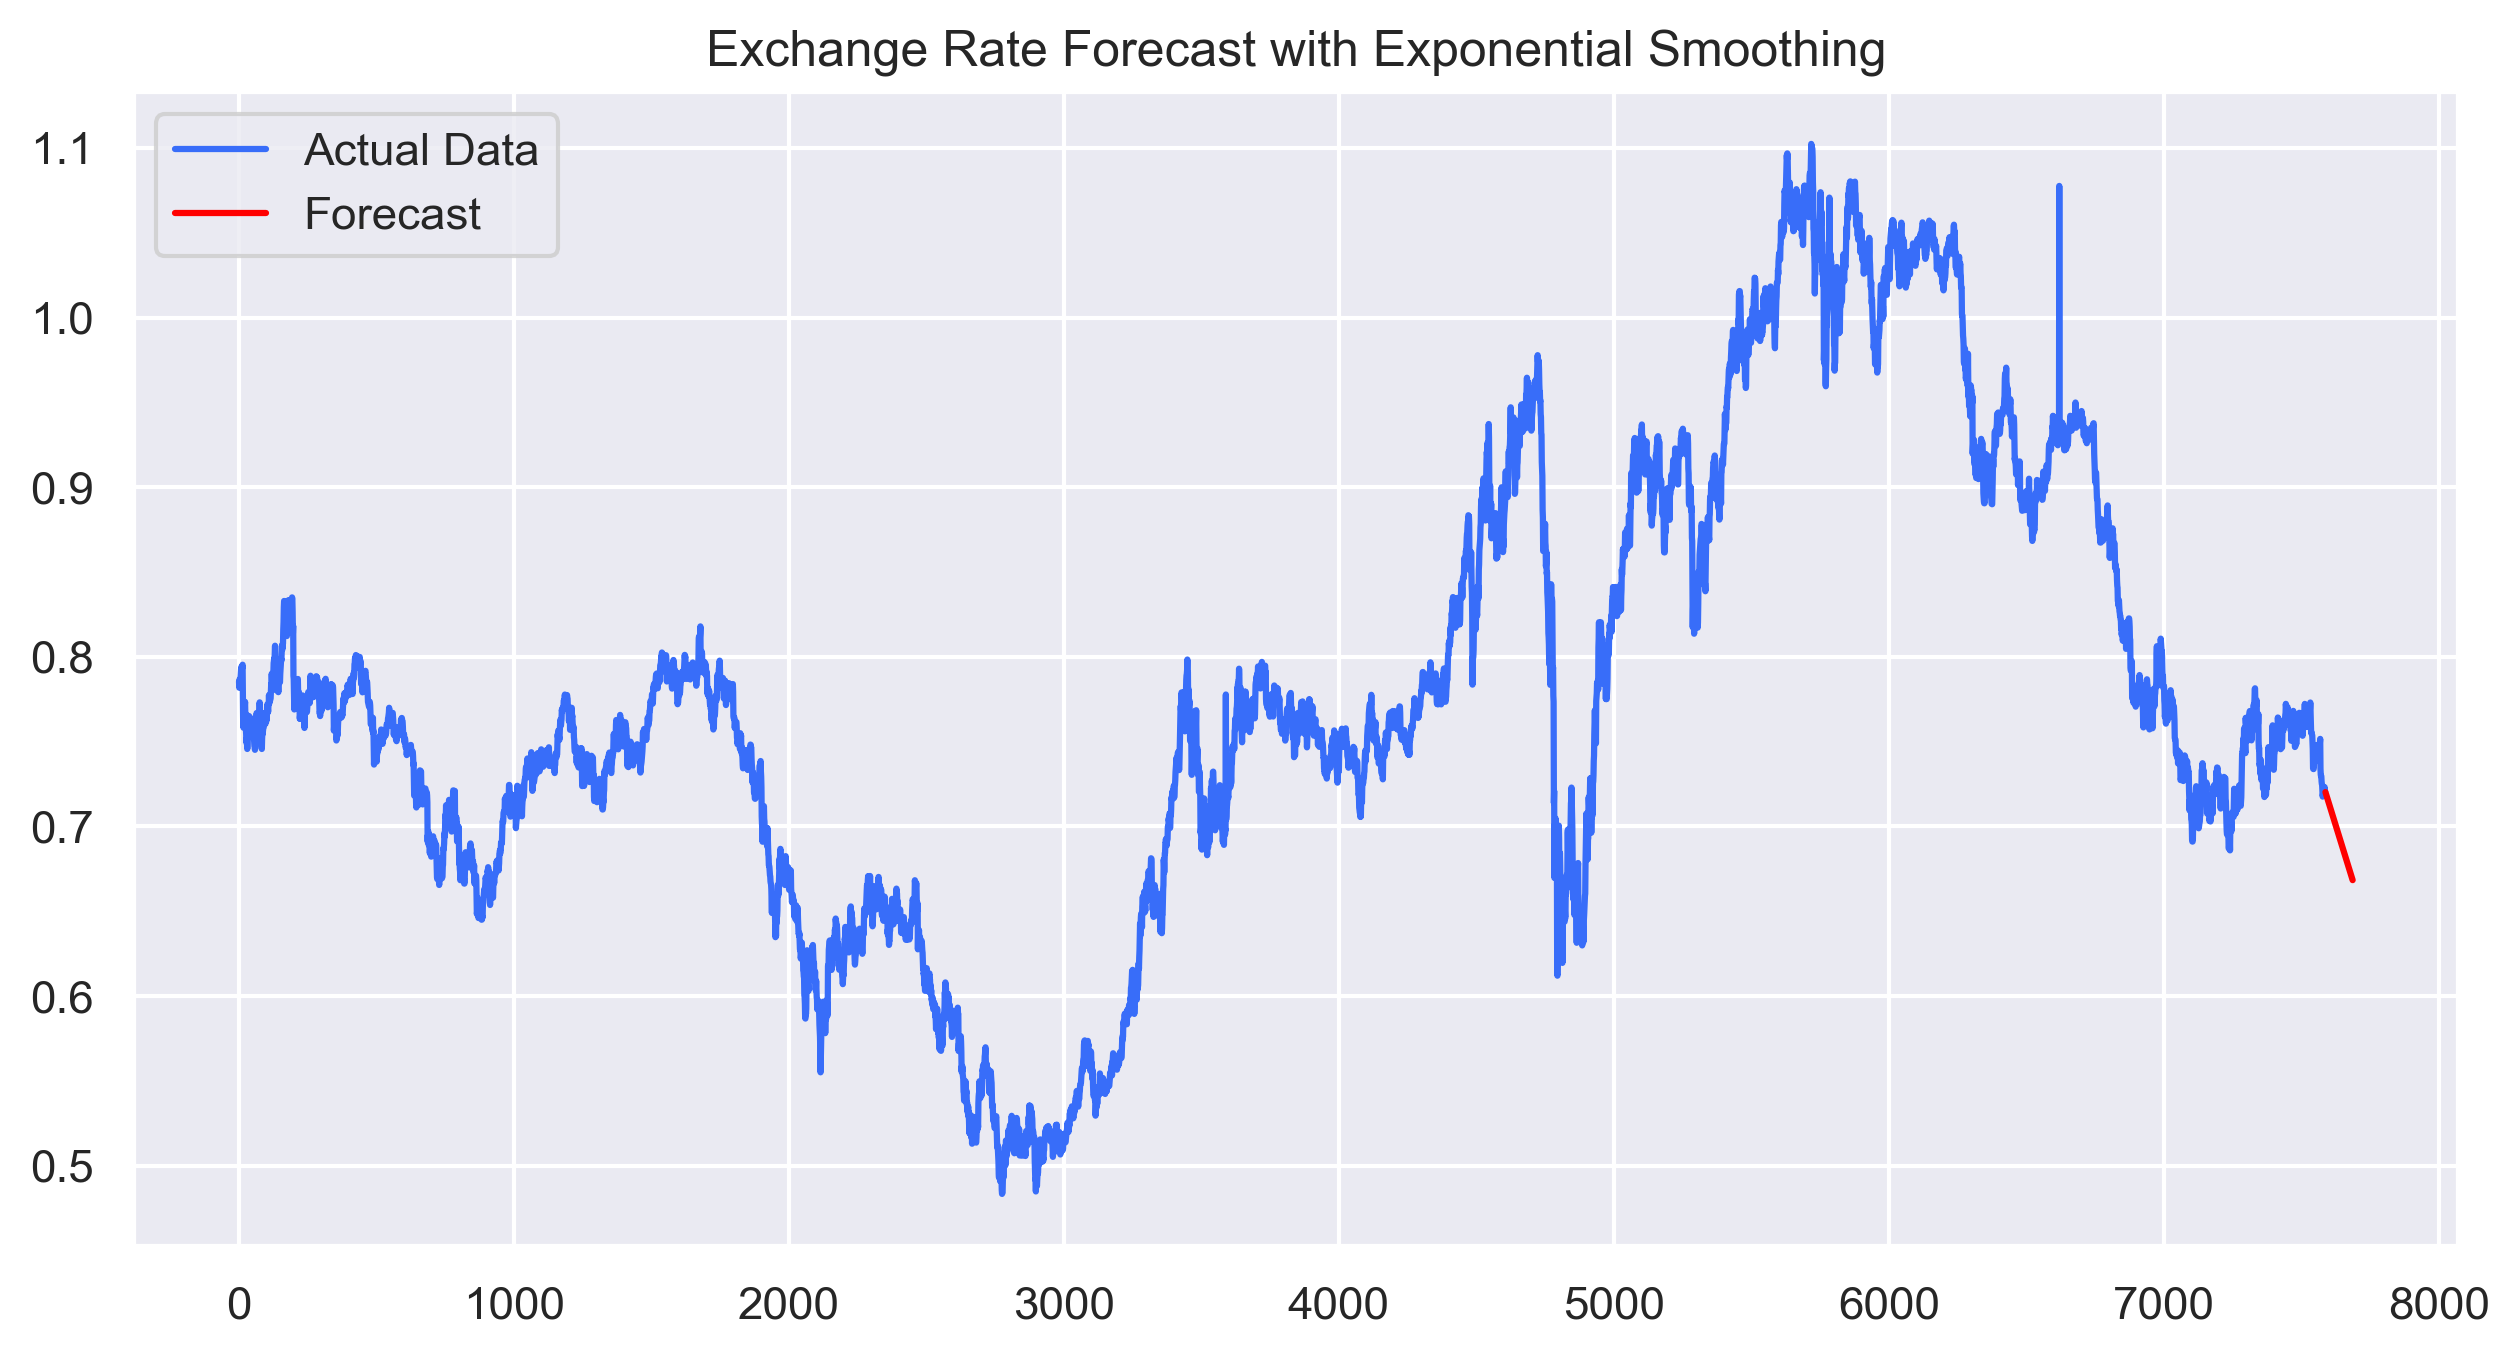

In [33]:
# plotting actual data and forecast
plt.plot(exchange_rate, label='Actual Data')
plt.plot(forecast, label='Forecast', color='red')
plt.legend()
plt.title('Exchange Rate Forecast with Exponential Smoothing')
plt.show()

#### Evaluation and Comparison

In [51]:
# compute Error Metrics 
from sklearn.metrics import mean_absolute_error, mean_squared_error
def calculate_error_metrics(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    rmse = mean_squared_error(actual, forecast, squared=False)
    mape = (np.mean(np.abs((actual - forecast) / actual))) * 100
    
    return mae, rmse, mape

In [52]:
actual_data = exchange_rate[:100]
forecasted_data = forecast
mae, rmse, mape = calculate_error_metrics(actual_data, forecasted_data)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

MAE: 0.0696852320852673
RMSE: 0.07103278586613677
MAPE: nan%


In [55]:
# model comparison 
'''
1. Arima Model 
Advantages : ARIMA works well with data that shows both trend and seasonality and allows for the integration of both 
autoregressive and moving average components
Limitations : ARIMA assumes that the data is stationary (constant mean and variance over time), which may not always 
be the case

2. Exponential Smoothing (Holt's Linear Model)
Advantages : Works well with data that has a trend but no seasonality. It's easy to interpret and implement and doesn't 
require stationarity.
Limitations : May underperform in datasets with more complex seasonal components or multiple levels of seasonality.'''

"\n1. Arima Model \nAdvantages : ARIMA works well with data that shows both trend and seasonality and allows for the \nintegration of both autoregressive and moving average components\nLimitations : ARIMA assumes that the data is stationary (constant mean and variance over time), \nwhich may not always be the case\n\n2. Exponential Smoothing (Holt's Linear Model)\nAdvantages : Works well with data that has a trend but no seasonality. It's easy to interpret and \nimplement and doesn't require stationarity.\nLimitations : May underperform in datasets with more complex seasonal components or multiple levels of seasonality."

In [58]:
# Conclusion 
'''
1. If ARIMA yields lower MAE, RMSE, and MAPE, it suggests that capturing both the autoregressive and moving average components
was beneficial for this dataset.
2. If Exponential Smoothing (Holt’s) performs better, it suggests that the data's trend could be effectively captured without 
additional complexity.'''

"\n1. If ARIMA yields lower MAE, RMSE, and MAPE, it suggests that capturing both the autoregressive and moving average components\nwas beneficial for this dataset.\n2. If Exponential Smoothing (Holt’s) performs better, it suggests that the data's trend could be effectively captured without \nadditional complexity."